# SINDyCP Feature Overview
This notebook provides an overview of the SINDyCP for discovery of parameterized pattern formation in PySINDy. Jupyter notebook written by Zachary G. Nicolaou.

Model pattern formation equations typically encode the effects of external drive through a number of driving parameters, which characterize a bifurcation leading to the onset of instability. While driving parameters can be considered as constant control signals for spatiotemporal dynamics, combining the PDEFIND and SINDYc approaches to discover parameterized spatiotemporal dynamics poses a significant challenge.
Here, we develop the system identification for nonlinear dynamics with control parameters (SINDyCP) approach to discover such parameterized dynamics.

In [1]:
import matplotlib.pyplot as plt

plt.ion()
import pysindy as ps
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import timeit
import os
import utils

### Fit a parameterized logistic map
The logistic map
$$ x_{n+1} = r x_n(1-x_n)$$
depends on one parameter $r$.  The behavior is chaotic for r>3.6

In [2]:
num = 1000
N = 1000
N_drop = 500
r0 = 3.5
rs = r0 + np.arange(num) / num * (4 - r0)
xss = []
for r in rs:
    xs = []
    x = 0.5
    for n in range(N + N_drop):
        if n >= N_drop:
            xs = xs + [x]
        x = r * x * (1 - x)
    xss = xss + [xs]

plt.figure(figsize=(4, 4), dpi=100)
for ind in range(num):
    plt.plot(np.ones(N) * rs[ind], xss[ind], ",", alpha=0.1, c="black", rasterized=True)
plt.xlabel("$r$")
plt.ylabel("$x_n$")
plt.savefig("logistic.pdf")
plt.show()

Generate data for four trajectories with differing values of $r=3.6,3.7,3.8,3.9$.

In [4]:
N = 1000
N_drop = 500

rs = [3.6, 3.7, 3.8, 3.9]
xss = []
for r in rs:
    xs = []
    x = 0.5
    for n in range(N + N_drop):
        if n >= N_drop:
            xs = xs + [x]
        x = r * x * (1 - x)
    xss = xss + [np.array(xs)]

Create a SINDyCP library, with a polynomial degree 3 feature library and a polynomial degree 1 parameter library. The library terms in a SINDyCP library consists of products of the features in the feature library and the parameter library. We input specify the parameter values for each trajectory using the control input, which must be the same shape as the input data.

In [5]:
feature_lib = ps.PolynomialLibrary(degree=3, include_bias=True)
parameter_lib = ps.PolynomialLibrary(degree=1, include_bias=True)
lib = ps.ParameterizedLibrary(
    feature_library=feature_lib,
    parameter_library=parameter_lib,
    num_features=1,
    num_parameters=1,
)
opt = ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(
    feature_library=lib, optimizer=opt, feature_names=["x", "r"], discrete_time=True
)
# model.fit(xss, u=[np.ones(N) * rs[ind] for ind in range(len(rs))], multiple_trajectories=True)
model.fit(xss, u=rs, multiple_trajectories=True)
model.print()

(x)[k+1] = 1.000 r[k] x[k] + -1.000 r[k] x[k]^2


### Fit a parameterized Lorenz model
The Lorenz equations
$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z. $$
depend on 3 parameters, $\sigma$, $\rho$, and $\beta$. We generate 10 trajectories with different parameter values.

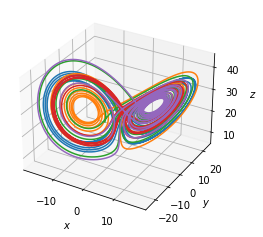

In [6]:
num_trajectories = 5
scalesigma = 1
scalerho = 1
scalebeta = 1
dt = 0.002

np.random.seed(100)
sigmas = 10 + scalesigma * (np.random.random(num_trajectories) - 0.5)
rhos = 28 * np.ones(num_trajectories) + scalerho * (
    np.random.random(num_trajectories) - 0.5
)
betas = 2.66667 * np.ones(num_trajectories) + scalebeta * (
    np.random.random(num_trajectories) - 0.5
)

x_trains, t_trains = utils.get_lorenz_trajectories(sigmas, rhos, betas, dt)

fig = plt.figure(figsize=(4, 4))
ax = plt.axes(projection="3d")

for i in range(len(x_trains)):
    ax.plot(x_trains[i][:, 0], x_trains[i][:, 1], x_trains[i][:, 2])

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
plt.savefig("lorenz.pdf")
plt.show()

Fitting any one trajectory gives the equation corresponding to a specific set of parameter values. Can we discover the parameterized equations given all the trajectories?

In [7]:
lib = ps.PolynomialLibrary()
opt = ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(
    feature_library=lib,
    optimizer=opt,
    feature_names=["x", "y", "z", "sigma", "rho", "beta"],
)
model.fit(x_trains[-1], t=dt)
model.print()
print([sigmas[-1], rhos[-1], betas[-1]])
print(lib.get_feature_names(["x", "y", "z", "sigma", "rho", "beta"]))

(x)' = -9.504 x + 9.504 y
(y)' = 28.068 x + -0.999 y + -1.000 x z
(z)' = -2.386 z + 1.000 x y
[9.504718856190973, 28.07509332942725, 2.3863674926249923]
['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2']


We use the control input of ps.model to specify the parameter values, and fit a SINDy model with multiple trajectories.

PySINDy will broadcast the control input shape to match the input data shape internally, so we send a list of the parameter values for each trajectory

Fitting a PolynomialLibrary with multiple_trajectories=True gives the correct model, but note that the same library functions are applied to the input features and the control input.

In [8]:
u_trains = [[sigmas[i], rhos[i], betas[i]] for i in range(len(sigmas))]
lib = ps.PolynomialLibrary()
opt = ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(
    feature_library=lib,
    optimizer=opt,
    feature_names=["x", "y", "z", "sigma", "rho", "beta"],
)
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()
print(lib.get_feature_names(["x", "y", "z", "sigma", "rho", "beta"]))

(x)' = -1.000 x sigma + 1.000 y sigma
(y)' = -0.999 y + -1.000 x z + 1.000 x rho
(z)' = 1.000 x y + -1.000 z beta
['1', 'x', 'y', 'z', 'sigma', 'rho', 'beta', 'x^2', 'x y', 'x z', 'x sigma', 'x rho', 'x beta', 'y^2', 'y z', 'y sigma', 'y rho', 'y beta', 'z^2', 'z sigma', 'z rho', 'z beta', 'sigma^2', 'sigma rho', 'sigma beta', 'rho^2', 'rho beta', 'beta^2']


The ParameterizedLibrary enables different libraries to be applied to the control input and input features. In this case, the result is the same, but different libraries are required for the PDE case, as shown below.

In [9]:
feature_library = ps.PolynomialLibrary(degree=2)
parameter_library = ps.PolynomialLibrary(degree=1)
lib = ps.ParameterizedLibrary(
    feature_library=feature_library,
    parameter_library=parameter_library,
    num_parameters=3,
)
opt = ps.STLSQ(threshold=1e-1, normalize_columns=False)
model = ps.SINDy(
    feature_library=lib,
    optimizer=opt,
    feature_names=["x", "y", "z", "sigma", "rho", "beta"],
)
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()
print(lib.get_feature_names(["x", "y", "z", "sigma", "rho", "beta"]))

(x)' = -1.000 sigma x + 1.000 sigma y
(y)' = -0.999 1 y + -1.000 1 x z + 1.000 rho x
(z)' = 1.000 1 x y + -1.000 beta z
['1 1', '1 x', '1 y', '1 z', '1 x^2', '1 x y', '1 x z', '1 y^2', '1 y z', '1 z^2', 'sigma 1', 'sigma x', 'sigma y', 'sigma z', 'sigma x^2', 'sigma x y', 'sigma x z', 'sigma y^2', 'sigma y z', 'sigma z^2', 'rho 1', 'rho x', 'rho y', 'rho z', 'rho x^2', 'rho x y', 'rho x z', 'rho y^2', 'rho y z', 'rho z^2', 'beta 1', 'beta x', 'beta y', 'beta z', 'beta x^2', 'beta x y', 'beta x z', 'beta y^2', 'beta y z', 'beta z^2']


### Fit a parameterized complex Ginzburg-Landau equation
The complex Ginzburg-Landau equation
$$ \dot{A} = A + (1+ib)\nabla^2 A - (1-ic)|A|^2A$$
describes the evolution of the mode amplitude $A$ for pattern formation in a long-wavelength, supercritical Hopf bifurcation. It depends on two parameters $b$ and $c$. We generate 4 trajectories with different values of the parameters. (Note: this will take a few minutes on the first run, but trajectories are saved and reloaded if present)

In [10]:
nx = 128
ny = 128
L = 16
t1 = 2e2
t3 = 1.9e2
if __name__ == "testing":
    t1 = 1e0
    t3 = 0
    nx = 32
    ny = 32
dt = 1e-1
nt = int((t1 - t3) / dt)

spatial_grid = np.zeros((nx, ny, 2))
spatial_grid[:, :, 0] = (np.arange(nx) - nx // 2)[:, np.newaxis] * 2 * np.pi * L / nx
spatial_grid[:, :, 1] = (np.arange(nx) - nx // 2)[np.newaxis, :] * 2 * np.pi * L / nx
spatiotemporal_grid = np.zeros((nx, ny, nt, 3))
spatiotemporal_grid[:, :, :, :2] = spatial_grid[:, :, np.newaxis, :]
spatiotemporal_grid[:, :, :, 2] = dt * np.arange(nt)

In [11]:
bs = [2.0, 2.0, 0.5, 1.0]
cs = [1.0, 0.75, 0.5, 0.75]
scales = [1e-1, 1e-1, 1e-1, 1e0]
scales2 = [1e-2, 1e-2, 1e0, 1e-2]
us = [[bs[i], cs[i]] for i in range(len(bs))]

if (
    np.all([os.path.exists("data/cgle/cgle_x" + str(i) + ".npy") for i in range(4)])
    and __name__ != "testing"
):
    xs = [np.load("data/cgle/cgle_x" + str(i) + ".npy") for i in range(4)]
else:
    xs = []
    for i in range(len(bs)):
        b = bs[i]
        c = cs[i]
        scale0 = scales[i]
        scale2 = scales2[i]
        x0 = utils.get_cgle_ic(scale0, scale2, spatial_grid)
        x = utils.get_cgle_trajectory(b, c, x0, t1, t3, dt, spatial_grid)
        xs = xs + [x]
    if __name__ != "testing":
        for i in range(len(xs)):
            if not os.path.exists("data/cgle"):
                os.mkdir("data/cgle")
            np.save("data/cgle/cgle_x" + str(i), xs[i])

Depending on the parameter values and initial conditions, the system exhibits different dynamical phases.

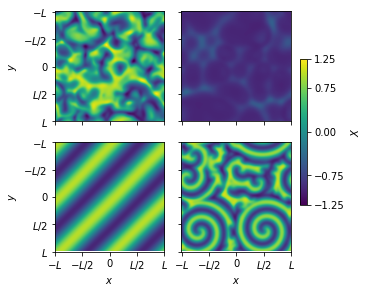

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(5, 4), constrained_layout=True)

for i in range(len(xs)):
    plt.subplot(2, 2, i + 1)
    pl = plt.imshow(xs[i][:, :, -1, 0], vmin=-1.25, vmax=1.25)
    plt.gca().set_xticks([0, 32, 64, 96, 128])
    plt.gca().set_xticklabels(["$-L$", "$-L/2$", "0", "$L/2$", "$L$"])
    plt.gca().set_yticks([0, 32, 64, 96, 128])
    plt.gca().set_yticklabels(["$-L$", "$-L/2$", "0", "$L/2$", "$L$"])
    if i == 2 or i == 3:
        plt.xlabel("$x$")
    else:
        plt.gca().set_xticklabels([])
    if i == 0 or i == 2:
        plt.ylabel("$y$")
    else:
        plt.gca().set_yticklabels([])

cbar = plt.colorbar(
    pl,
    ax=axs[:, 1],
    orientation="vertical",
    ticks=[-1.25, -0.75, 0.00, 0.75, 1.25],
    label="$X$",
    shrink=0.6,
)
plt.savefig("cgle.pdf")
plt.show()

Fitting any one trajectory gives the equation corresponding to a specific set of parameter values. Can we discover the parameterized equations given all the trajectories?

In [13]:
start = timeit.default_timer()
lib = ps.PDELibrary(
    library_functions=[
        lambda x: x,
        lambda x: x**3,
        lambda x, y: x**2 * y,
        lambda x, y: y**2 * x,
    ],
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_interaction=False,
    function_names=[
        lambda x: x,
        lambda x: x + x + x,
        lambda x, y: x + x + y,
        lambda x, y: x + y + y,
    ],
    differentiation_method=ps.SpectralDerivative,
)
opt = ps.STLSQ(threshold=1e-1, alpha=1e-3)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["X", "Y"])
model.fit(xs[-1], t=dt)
model.print()
stop = timeit.default_timer()
print(stop - start)

(X)' = 0.999 X + -0.999 XXX + -0.750 YYY + -0.750 XXY + -0.999 XYY + 0.999 X_22 + -0.999 Y_22 + 0.999 X_11 + -0.999 Y_11
(Y)' = 0.999 Y + 0.750 XXX + -0.999 YYY + -0.999 XXY + 0.750 XYY + 0.999 X_22 + 0.999 Y_22 + 0.999 X_11 + 0.999 Y_11
4.675402078000001


Try a SINDy model with multiple trajectories using the ParameterizedLibrary. Use a PDELibrary for the feature_library with second-order derivatives and library functions that include the relevant cubic term. Use a PDELibrary for the parameter_library with zeroth-order derivatives and linear library functions. The fit is very good!

In [14]:
start = timeit.default_timer()
library_functions = [
    lambda x: x,
    lambda x: x**3,
    lambda x, y: x**2 * y,
    lambda x, y: y**2 * x,
]
function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + x + y,
    lambda x, y: x + y + y,
]
feature_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_interaction=False,
    function_names=function_names,
)
library_functions = [lambda x: x]
function_names = [lambda x: x]
parameter_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=0,
    include_interaction=False,
    function_names=function_names,
    include_bias=True,
)
lib = ps.ParameterizedLibrary(
    parameter_library=parameter_lib,
    feature_library=feature_lib,
    num_parameters=2,
    num_features=2,
)
opt = ps.STLSQ(threshold=5e-1, alpha=1e-3, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["x", "y", "b", "c"])
model.fit(xs, u=us, t=dt, multiple_trajectories=True)
model.print()
stop = timeit.default_timer()
print(stop - start)
print(lib.get_feature_names(["x", "y", "b", "c"]))

(x)' = 0.988 1 x + -0.987 1 xxx + -0.986 1 xyy + 1.015 1 x_22 + 1.020 1 x_11 + -1.020 b y_22 + -1.018 b y_11 + -1.000 c yyy + -1.000 c xxy
(y)' = 0.989 1 y + -0.987 1 yyy + -0.987 1 xxy + 1.017 1 y_22 + 1.021 1 y_11 + 1.021 b x_22 + 1.019 b x_11 + 1.000 c xxx + 1.000 c xyy
90.058883999
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


Modifying PDELibrary to accept spectral derivatives improves the fit a bit

In [15]:
start = timeit.default_timer()
library_functions = [
    lambda x: x,
    lambda x: x**3,
    lambda x, y: x**2 * y,
    lambda x, y: y**2 * x,
]
function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + x + y,
    lambda x, y: x + y + y,
]
feature_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_interaction=False,
    function_names=function_names,
    differentiation_method=ps.SpectralDerivative,
)
library_functions = [lambda x: x]
function_names = [lambda x: x]
parameter_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=0,
    include_interaction=False,
    function_names=function_names,
    include_bias=True,
)
lib = ps.ParameterizedLibrary(
    parameter_library=parameter_lib,
    feature_library=feature_lib,
    num_parameters=2,
    num_features=2,
)
opt = ps.STLSQ(threshold=1e-1, alpha=1e-3, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["x", "y", "b", "c"])
model.fit(xs, u=us, t=dt, multiple_trajectories=True)
model.print()
stop = timeit.default_timer()
print(stop - start)
print(lib.get_feature_names(["x", "y", "b", "c"]))

(x)' = 0.999 1 x + -0.999 1 xxx + -0.999 1 xyy + 0.999 1 x_22 + 0.999 1 x_11 + -0.999 b y_22 + -0.999 b y_11 + -0.999 c yyy + -0.999 c xxy
(y)' = 0.999 1 y + -0.999 1 yyy + -0.999 1 xxy + 0.999 1 y_22 + 0.999 1 y_11 + 0.999 b x_22 + 0.999 b x_11 + 0.999 c xxx + 0.999 c xyy
87.74377966799999
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


If we ensure the same domain cells are used in the feature library and the parameter library (by reseeding np.random), the WeakLibrary can be used with the ParameterLibrary. (In this case, the parameters need to be constants, so that the tensor product of two WeakLibrary corresponds to the correct weak features.) The fit is perfect and super fast!

In [16]:
start = timeit.default_timer()
np.random.seed(100)
library_functions = [
    lambda x: x,
    lambda x: x**3,
    lambda x, y: x**2 * y,
    lambda x, y: y**2 * x,
]
function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + x + y,
    lambda x, y: x + y + y,
]
feature_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    derivative_order=2,
    spatiotemporal_grid=spatiotemporal_grid,
    include_interaction=False,
    function_names=function_names,
    K=500,
    H_xt=[L * 2 * np.pi / 10, L * 2 * np.pi / 10, (t1 - t3) / 10],
)
np.random.seed(100)
library_functions = [lambda x: x]
function_names = [lambda x: x]
parameter_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    spatiotemporal_grid=spatiotemporal_grid,
    derivative_order=0,
    include_interaction=False,
    function_names=function_names,
    include_bias=True,
    K=500,
    H_xt=[L * 2 * np.pi / 10, L * 2 * np.pi / 10, (t1 - t3) / 10],
)
lib = ps.ParameterizedLibrary(
    parameter_library=parameter_lib,
    feature_library=feature_lib,
    num_parameters=2,
    num_features=2,
)
opt = ps.STLSQ(threshold=1e-1, alpha=1e-3, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["x", "y", "b", "c"])
model.fit(xs, u=us, t=dt, multiple_trajectories=True)
model.print()
stop = timeit.default_timer()
print(stop - start)
print(lib.get_feature_names(["x", "y", "b", "c"]))

(x)' = 1.000 1 x + -1.000 1 xxx + -1.000 1 xyy + 1.000 1 x_22 + 1.000 1 x_11 + -1.000 b y_22 + -1.000 b y_11 + -1.000 c yyy + -1.000 c xxy
(y)' = 1.000 1 y + -1.000 1 yyy + -1.000 1 xxy + 1.000 1 y_22 + 1.000 1 y_11 + 1.000 b x_22 + 1.000 b x_11 + 1.000 c xxx + 1.000 c xyy
16.080905747999992
['1 x', '1 y', '1 xxx', '1 yyy', '1 xxy', '1 xyy', '1 x_2', '1 y_2', '1 x_22', '1 y_22', '1 x_1', '1 y_1', '1 x_12', '1 y_12', '1 x_11', '1 y_11', 'b x', 'b y', 'b xxx', 'b yyy', 'b xxy', 'b xyy', 'b x_2', 'b y_2', 'b x_22', 'b y_22', 'b x_1', 'b y_1', 'b x_12', 'b y_12', 'b x_11', 'b y_11', 'c x', 'c y', 'c xxx', 'c yyy', 'c xxy', 'c xyy', 'c x_2', 'c y_2', 'c x_22', 'c y_22', 'c x_1', 'c y_1', 'c x_12', 'c y_12', 'c x_11', 'c y_11']


### Oregenator model for BZ chemical reaction

We consider the coupled reaction diffusion equations

$\dot{C}_X = k_1 C_A C_H^2 C_Y-k_2C_HC_XC_Y+k_3C_AC_HC_X-2k_4C_X^2  + D_X \nabla^2 C_X$

$\dot{C}_Y = -k_1C_AC_H^2C_Y-k_2C_HC_XC_Y + \nu k_5 C_B C_Z + D_Y \nabla^2 C_Y$

$\dot{C}_Z = 2k_3C_AC_HC_X-k_5C_BC_Z + D_Z \nabla^2 C_Z$

which constitute the classical Oregonator model for the BZ chemical reaction. We fix all parameters except $C_b=C_b^c(1 - \mu)$, and a supercritical Hopf bifurcation occurs at $\mu=0$. In the spatially homogeneous case, a small, stable limit cycle initially emerges for $\mu>0$, but this limit cycle rapid expands in a canard explosion around $\mu\approx 0.15$.

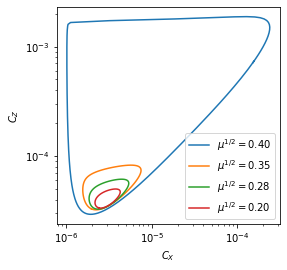

In [17]:
bs3 = np.linspace(0.84, 0.98, 8)

Xs = []
Ys = []
Zs = []
for b in bs3:
    t1 = 1e2 / (1 - b)  # Domain size in t directions
    if __name__ == "testing":
        t1 = 1e1 / (1 - b)
    dt = 5.94804 / 100

    X, Y, Z = utils.get_homogeneous_oregonator_trajectory(b, t1, dt)
    Xs = Xs + [X]
    Ys = Ys + [Y]
    Zs = Zs + [Z]

# discard initial transients
plt.figure(figsize=(4, 4))
for i in range(0, len(bs3), 2):
    X = Xs[i]
    Z = Zs[i]
    nt = X.shape[0]
    period = int(np.median(np.diff(find_peaks(X[nt // 2 :])[0]))) + 1
    plt.plot(
        X[-period:], Z[-period:], label=r"$\mu^{1/2} = %.2f$" % ((1 - bs3[i]) ** 0.5)
    )
plt.xlabel("$C_X$")
plt.ylabel("$C_Z$")
plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.savefig("fig2b.pdf")
plt.show()

Integrate six trajectories with varying bs. This will take several hours to generate and save the data for the first time, but it will reload the files if they are present from a previous run.

In [18]:
bs = np.linspace(0.88, 0.98, 6)
n = 128  # Number of spatial points in each direction
Nt = 1000  # Number of temporal interpolation points

if __name__ == "testing":
    Nt = 100
    n = 32

X0, Y0, Z0 = utils.get_oregonator_ic(2e-1, 0, spatial_grid)
u0 = np.concatenate([X0.ravel(), Y0.ravel(), Z0.ravel()])

if not os.path.exists("data/oregonator"):
    os.mkdir("data/oregonator")
if not np.all(
    [
        os.path.exists("data/oregonator/oregonator_" + str(i) + ".npy")
        for i in range(len(bs))
    ]
):
    for j in range(len(bs)):
        if not os.path.exists("data/oregonator/oregonator_" + str(j) + ".npy"):
            b = bs[j]
            print(j, b)
            L = 1 / (1 - b) ** 0.5  # Domain size in X and Y directions
            spatial_grid = np.zeros((n, n, 2))
            spatial_grid[:, :, 0] = L / n * np.arange(n)[:, np.newaxis]
            spatial_grid[:, :, 1] = L / n * np.arange(n)[np.newaxis, :]
            t1 = 1e3 / (1 - b)  # Domain size in t directions
            if __name__ == "testing":
                t1 = 20
            dt = 5.94804

            start = timeit.default_timer()

            X, Y, Z = utils.get_oregonator_trajectory(u0, b, t1, dt, spatial_grid)

            x = np.array([X, Y, Z]).transpose(1, 2, 3, 0)
            fi = interp1d(np.arange(x.shape[2]), x, axis=2)
            x = fi(np.arange(Nt) / (Nt - 1) * (x.shape[2] - 1))
            plt.plot(np.mean(x[:, :, :, 0], axis=(0, 1)))
            plt.plot(np.mean(x[:, :, :, 2], axis=(0, 1)))
            plt.show()
            plt.imshow(x[:, :, -1, 0])
            plt.show()

            np.save("data/oregonator/oregonator_" + str(j), x)
            stop = timeit.default_timer()
            print(stop - start)

xs = [np.load("data/oregonator/oregonator_" + str(i) + ".npy") for i in range(len(bs))]

The SINDyCP fit reveals variations in the normal-form parameter that correct the weakly-nonlinear theory away from the instability, and these variations become extreme at the canard explosion.  First, split the trajectories into training and test data and define a quadrative parameter and a quintic feature libraries.

In [19]:
xs_train = []
xs_test = []
us = ((1 - bs) ** 0.5).tolist()
for i in range(len(bs)):
    U = xs[i][:, :, 2 * Nt // 5 :, [0, 2]]
    U = U - np.mean(U, axis=(0, 1, 2))
    U = U / np.mean(U**2, axis=(0, 1, 2)) ** 0.5
    xs_train = xs_train + [U[:, :, : Nt // 20]]
    xs_test = xs_test + [U[:, :, -Nt // 20 :]]
    #     #Using more data for a better fit requires a lot of memory (>100gb)
    #     xs_train=xs_train+[U[:,:,:2*Nt//5]]
    #     xs_test=xs_test+[U[:,:,2*Nt//5:]]

# rescale to a single time step and spatial_grid over all trajectories
spatial_grid = np.zeros((n, n, 2))
spatial_grid[:, :, 0] = 2 * np.arange(n)[:, np.newaxis]
spatial_grid[:, :, 1] = 2 * np.arange(n)[np.newaxis, :]
nt = xs_train[0].shape[2]
dt = 1e2 / nt

library_functions = [
    lambda x: x,
    lambda x: x**2,
    lambda x, y: x * y,
    lambda x: x**3,
    lambda x, y: x**2 * y,
    lambda x, y: y**2 * x,
    lambda x: x**4,
    lambda x, y: x**3 * y,
    lambda x, y: x**2 * y**2,
    lambda x, y: x * y**3,
    lambda x: x**5,
    lambda x, y: x**4 * y,
    lambda x, y: x**3 * y**2,
    lambda x, y: x**2 * y**3,
    lambda x, y: x * y**4,
]
function_names = [
    lambda x: x,
    lambda x: x + x,
    lambda x, y: x + y,
    lambda x: x + x + x,
    lambda x, y: x + x + y,
    lambda x, y: x + y + y,
    lambda x: x + x + x + x,
    lambda x, y: x + x + x + y,
    lambda x, y: x + x + y + y,
    lambda x, y: x + y + y + y,
    lambda x: x + x + x + x + x,
    lambda x, y: x + x + x + x + y,
    lambda x, y: x + x + x + y + y,
    lambda x, y: x + x + y + y + y,
    lambda x, y: x + y + y + y + y,
]
feature_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=2,
    spatial_grid=spatial_grid,
    temporal_grid=dt * np.arange(nt),
    include_interaction=False,
    implicit_terms=True,
    function_names=function_names,
    differentiation_method=ps.SpectralDerivative,
)
feature_lib.multiindices = np.array([[0, 0, 1], [0, 2, 0], [2, 0, 0]])
feature_lib.num_derivatives = len(feature_lib.multiindices)

library_functions = [lambda x: x, lambda x: x**2]
function_names = [lambda x: x, lambda x: x + x]

parameter_lib = ps.PDELibrary(
    library_functions=library_functions,
    derivative_order=0,
    include_interaction=False,
    function_names=function_names,
    include_bias=True,
)
lib = ps.ParameterizedLibrary(
    parameter_library=parameter_lib,
    feature_library=feature_lib,
    num_parameters=1,
    num_features=2,
)

We run the fit with a constrained SR3 optimizer, which allows us to ensure that the derivative terms remain rotationally invariant. Then we evaluate the scores on the test data.

In [20]:
shape = np.array(xs_train[0].shape)
shape[-1] = 1
lib.fit(np.concatenate([xs_train[0], us[0] * np.ones(shape)], axis=-1))

n_targets = 2
num_mus = 1 + len(library_functions)
constraint_rhs = np.zeros(4 * num_mus)
n_features = len(lib.get_feature_names())
constraint_lhs = np.zeros((4 * num_mus, n_targets * n_features))
x11inds = np.where(
    np.array([name.split(" ")[1] for name in lib.get_feature_names()]) == "x0_11"
)[0]
x22inds = np.where(
    np.array([name.split(" ")[1] for name in lib.get_feature_names()]) == "x0_22"
)[0]
y11inds = np.where(
    np.array([name.split(" ")[1] for name in lib.get_feature_names()]) == "x1_11"
)[0]
y22inds = np.where(
    np.array([name.split(" ")[1] for name in lib.get_feature_names()]) == "x1_22"
)[0]

constraint = 0
for i in range(num_mus):
    constraint_lhs[constraint, x11inds[i]] = 1
    constraint_lhs[constraint, x22inds[i]] = -1
    constraint = constraint + 1
    constraint_lhs[constraint, x11inds[i] + n_features] = 1
    constraint_lhs[constraint, x22inds[i] + n_features] = -1
    constraint = constraint + 1

    constraint_lhs[constraint, y11inds[i]] = 1
    constraint_lhs[constraint, y22inds[i]] = -1
    constraint = constraint + 1
    constraint_lhs[constraint, y11inds[i] + n_features] = 1
    constraint_lhs[constraint, y22inds[i] + n_features] = -1
    constraint = constraint + 1

opt = ps.ConstrainedSR3(
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    thresholder="l1",
    tol=1e-3,
    threshold=1e-2,
)
if __name__ == "testing":
    opt = ps.ConstrainedSR3(
        constraint_rhs=constraint_rhs,
        constraint_lhs=constraint_lhs,
        thresholder="l1",
        tol=1e-3,
        threshold=1e-6,
    )

model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["X", "Y", "mu"])

start = timeit.default_timer()
model.fit(xs_train, u=us, t=dt, multiple_trajectories=True)
model.print()
stop = timeit.default_timer()
print(stop - start)
print(
    model.score(
        xs_test, u=us, t=dt, multioutput="raw_values", multiple_trajectories=True
    )
)

scores = []
for i in range(len(xs_train)):
    scores = scores + [
        model.score(
            xs_test[i],
            u=us[i],
            t=dt,
            multioutput="raw_values",
            multiple_trajectories=False,
        )
    ]

/Users/zack/pysindy/pysindy/optimizers/constrained_sr3.py:439: ConvergenceWarning: SR3._reduce did not converge after 30 iterations.
  warnings.warn(


(X)' = -0.106 1 X + 0.239 1 Y + -0.020 1 XX + -0.133 1 YY + 0.083 1 XY + -0.042 1 XXX + 0.169 1 YYY + 0.235 1 XXY + -0.292 1 XYY + 0.033 1 XXXX + 0.076 1 YYYY + -0.146 1 XXXY + 0.275 1 XXYY + -0.224 1 XYYY + -0.023 1 YYYYY + -0.044 1 XXXXY + 0.127 1 XXXYY + -0.162 1 XXYYY + 0.101 1 XYYYY + 0.068 1 Y_t + 0.210 1 X_22 + -0.014 1 Y_22 + 0.210 1 X_11 + -0.014 1 Y_11 + -0.082 mu X + 1.454 mu Y + 0.208 mu XX + 1.723 mu YY + -0.698 mu XY + -0.490 mu XXX + -0.911 mu YYY + -0.567 mu XXY + 1.132 mu XYY + -0.623 mu XXXX + -1.140 mu YYYY + 2.240 mu XXXY + -3.973 mu XXYY + 3.143 mu XYYY + -0.014 mu XXXXX + 0.425 mu YYYYY + 0.856 mu XXXXY + -1.997 mu XXXYY + 2.437 mu XXYYY + -1.503 mu XYYYY + -1.796 mu X_t + -0.510 mu Y_t + 0.107 mu X_22 + 0.792 mu Y_22 + 0.107 mu X_11 + 0.792 mu Y_11 + -0.059 mumu X + -3.440 mumu Y + -0.604 mumu XX + -2.936 mumu YY + 1.776 mumu XY + 0.824 mumu XXX + 2.685 mumu YYY + 2.777 mumu XXY + -4.153 mumu XYY + 1.095 mumu XXXX + 1.337 mumu YYYY + -3.671 mumu XXXY + 5.785 mumu

Apply a nonlinear transformation to discover the normal-form parameters for the SINDyCP fit.

In [38]:
Xts = np.where(
    [feat.split(" ")[1] == "X_t" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
Yts = np.where(
    [feat.split(" ")[1] == "Y_t" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
Xs = np.where(
    [feat.split(" ")[1] == "X" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
Ys = np.where(
    [feat.split(" ")[1] == "Y" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
XXs = np.where(
    [feat.split(" ")[1] == "XX" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
XYs = np.where(
    [feat.split(" ")[1] == "XY" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
YYs = np.where(
    [feat.split(" ")[1] == "YY" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
XXXs = np.where(
    [feat.split(" ")[1] == "XXX" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
XXYs = np.where(
    [feat.split(" ")[1] == "XXY" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
XYYs = np.where(
    [feat.split(" ")[1] == "XYY" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
YYYs = np.where(
    [feat.split(" ")[1] == "YYY" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
X11s = np.where(
    [feat.split(" ")[1] == "X_11" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
X12s = np.where(
    [feat.split(" ")[1] == "X_12" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
X22s = np.where(
    [feat.split(" ")[1] == "X_22" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
Y11s = np.where(
    [feat.split(" ")[1] == "Y_11" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
Y12s = np.where(
    [feat.split(" ")[1] == "Y_12" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]
Y22s = np.where(
    [feat.split(" ")[1] == "Y_22" for feat in lib.get_feature_names(["X", "Y", "mu"])]
)[0]

In [22]:
bs2 = np.linspace(0.85, 0.995, 1000)
mus = (1 - bs2)[np.newaxis, :] ** (np.arange(len(Xs))[:, np.newaxis] * 0.5)

D = np.zeros((len(bs2), 2, 2))
D[:, :, 0] = mus.T.dot(opt.coef_[:, X11s].T)
D[:, :, 1] = mus.T.dot(opt.coef_[:, Y11s].T)

L = np.zeros((len(bs2), 2, 2))
L[:, :, 0] = [1, 0] - (mus.T.dot(opt.coef_[:, Xts].T))
L[:, :, 1] = [0, 1] - (mus.T.dot(opt.coef_[:, Yts].T))

J = np.zeros((len(bs2), 2, 2))
Fxx = np.zeros((len(bs2), 2, 2, 2))
Fxxx = np.zeros((len(bs2), 2, 2, 2, 2))
J[:, :, 0] = mus.T.dot(opt.coef_[:, Xs].T)
J[:, :, 1] = mus.T.dot(opt.coef_[:, Ys].T)
Fxx[:, :, 0, 0] = (mus.T.dot(opt.coef_[:, XXs].T)) * 2
Fxx[:, :, 0, 1] = mus.T.dot(opt.coef_[:, XYs].T)
Fxx[:, :, 1, 0] = mus.T.dot(opt.coef_[:, XYs].T)
Fxx[:, :, 1, 1] = (mus.T.dot(opt.coef_[:, YYs].T)) * 2
Fxxx[:, :, 0, 0, 0] = (mus.T.dot(opt.coef_[:, XXXs].T)) * 6
Fxxx[:, :, 0, 0, 1] = (mus.T.dot(opt.coef_[:, XXYs].T)) * 2
Fxxx[:, :, 0, 1, 0] = (mus.T.dot(opt.coef_[:, XXYs].T)) * 2
Fxxx[:, :, 1, 0, 0] = (mus.T.dot(opt.coef_[:, XXYs].T)) * 2
Fxxx[:, :, 0, 1, 1] = (mus.T.dot(opt.coef_[:, XYYs].T)) * 2
Fxxx[:, :, 1, 0, 1] = (mus.T.dot(opt.coef_[:, XYYs].T)) * 2
Fxxx[:, :, 1, 1, 0] = (mus.T.dot(opt.coef_[:, XYYs].T)) * 2
Fxxx[:, :, 1, 1, 1] = (mus.T.dot(opt.coef_[:, YYYs].T)) * 6

lambdas, Us = np.linalg.eig(np.einsum("aij,ajk->aik", np.linalg.inv(L), J))

In [23]:
u = Us[:, :, 0]
ubar = np.conjugate(u)
ut = np.linalg.inv(Us)[:, 0, :]
a = np.einsum(
    "ni,nip,npjk,nj,nkl,nlmo,nm,no->n",
    ut,
    np.linalg.inv(L),
    Fxx,
    u,
    np.linalg.inv(J),
    Fxx,
    u,
    ubar,
)
b = (
    np.einsum(
        "ni,nip,npjk,nj,nkl,nlmo,nm,no->n",
        ut,
        np.linalg.inv(L),
        Fxx,
        ubar,
        np.linalg.inv(
            J
            - (
                (lambdas[:, 0] - lambdas[:, 1])[:, np.newaxis, np.newaxis]
                * np.eye(2)[np.newaxis, :, :]
            )
        ),
        Fxx,
        u,
        u,
    )
    / 2
)
c = np.einsum("ni,nip,npjkl,nj,nk,nl->n", ut, np.linalg.inv(L), Fxxx, u, u, ubar) / 2
alphas = a + b - c
alphas = -np.imag(alphas) / np.real(alphas)
print(alphas[0], alphas[-1])
betas = np.einsum("ni,nij,njk,nk->n", ut, np.linalg.inv(L), D, u)
betas = np.imag(betas) / np.real(betas)
print(betas[0], betas[-1])

15.413943168017159 4.375885311504442
0.3884372549227883 0.17573791683062995


Plot the normal-form parameters as a function of $\varepsilon$. The fit agrees with the weakly nonlinear prediction in the $\mu\to 0$ limit, and the variation with $\mu$ represents a correction to the theory. The variations become extreme around the canard explosion that occurs above $\mu^{1/2}=0.35$.

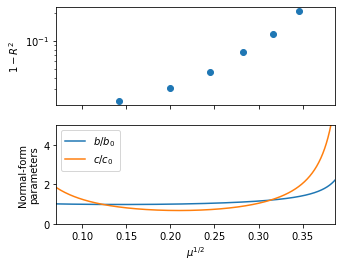

In [24]:
plt.subplots(2, 1, figsize=(5, 4))

plt.subplot(2, 1, 1)
plt.scatter((1 - bs) ** 0.5, 1 - np.mean(scores, axis=1))
plt.ylabel("$1-R^2$")
plt.gca().set_xticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35])
plt.gca().set_xticklabels([])
plt.xlim((1 - bs2[-1]) ** 0.5, (1 - bs2[0]) ** 0.5)
plt.yscale("log")

plt.subplot(2, 1, 2)
plt.plot((1 - bs2) ** 0.5, betas / (0.17272), label=r"$b/b_0$")
plt.plot((1 - bs2) ** 0.5, alphas / (2.37882), label=r"$c/c_0$")
plt.gca().set_xticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35])
plt.ylim(0, 5)
plt.legend()
plt.ylabel("Normal-form\nparameters")
plt.xlabel(r"$\mu^{1/2}$")
plt.xlim((1 - bs2[-1]) ** 0.5, (1 - bs2[0]) ** 0.5)
plt.savefig("fig2.pdf")
plt.show()

Calculate a finely resolved trajectory above the canard explosion, with $\mu=0.16$. The dynamics exhibit more extreme spatiotemporal variations than exhibited by the CGLE.

In [25]:
bs = [0.84]
n = 256  # Number of spatial points in each direction
Nt = 200  # Number of temporal interpolation points

if __name__ == "testing":
    Nt = 20
    n = 64

if not os.path.exists("data/oregonator"):
    os.mkdir("data/oregonator")
if not np.all(
    [
        os.path.exists("data/oregonator/canard_" + str(i) + ".npy")
        for i in range(len(bs))
    ]
):
    for j in range(len(bs)):
        if not os.path.exists("data/oregonator/canard_" + str(j) + ".npy"):
            b = bs[j]
            print(j, b)
            L = 1 / (1 - b) ** 0.5  # Domain size in X and Y directions
            spatial_grid = np.zeros((n, n, 2))
            spatial_grid[:, :, 0] = L / n * np.arange(n)[:, np.newaxis]
            spatial_grid[:, :, 1] = L / n * np.arange(n)[np.newaxis, :]
            t1 = 2e2 / (1 - b)  # Domain size in t directions
            if __name__ == "testing":
                t1 = 20
            dt = 5.94804
            X0, Y0, Z0 = utils.get_oregonator_ic(2e-1, 0, spatial_grid)
            u0 = np.concatenate([X0.ravel(), Y0.ravel(), Z0.ravel()])

            start = timeit.default_timer()

            X, Y, Z = utils.get_oregonator_trajectory(u0, b, t1, dt, spatial_grid)

            x = np.array([X, Y, Z]).transpose(1, 2, 3, 0)
            fi = interp1d(np.arange(x.shape[2]), x, axis=2)
            x = fi(np.arange(Nt) / (Nt - 1) * (x.shape[2] - 1))
            plt.plot(np.mean(x[:, :, :, 0], axis=(0, 1)))
            plt.plot(np.mean(x[:, :, :, 2], axis=(0, 1)))
            plt.show()
            plt.imshow(x[:, :, -1, 0])
            plt.show()

            np.save("data/oregonator/canard_" + str(j), x)
            stop = timeit.default_timer()
            print(stop - start)

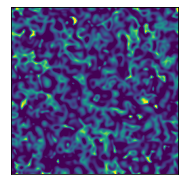

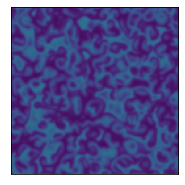

In [26]:
plt.figure(figsize=(3, 4))
x = np.load("data/oregonator/canard_0.npy")
plt.imshow(x[:, :, -1, 0])
plt.clim(2e-6, 8e-6)
plt.xticks([])
plt.yticks([])
plt.savefig("fig2c.pdf")
plt.show()
plt.figure(figsize=(3, 4))
x = np.load("data/oregonator/oregonator_4.npy")
plt.imshow(x[:, :, -1, 0])
plt.clim(2e-6, 8e-6)
plt.xticks([])
plt.yticks([])
plt.savefig("fig2d.pdf")
plt.show()

### Effects of noise on CGLE fits

Here we perform both differential and weak SINDyCP fits on the four previous trajectories with various intensities of injected noise. We generate two new test trajectories to assess the performance of the fits. We also generate five new training trajectories with random parameter values in the amplitude turbulence parameter regime and perform the SINDyCP fits on noisy data with a varying number of length of trajectories. Since these fits take a while, we use previously saved score results here if they are present.

In [27]:
utils.cgle_weak_noise_sweeps()
utils.cgle_noise_sweeps()

Plot results

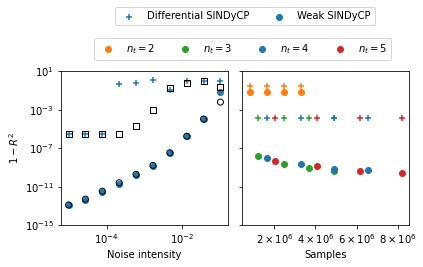

In [28]:
colors = [
    "#ff7f0e",
    "#2ca02c",
    "#1f77b4",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

plt.subplot(1, 2, 1)
scores0 = np.load("data/cgle/cgle_scores0.npy")
weak_scores0 = np.load("data/cgle/cgle_weak_scores0.npy")
scores1 = np.load("data/cgle/cgle_scores1.npy")
weak_scores1 = np.load("data/cgle/cgle_weak_scores1.npy")
plt.scatter(
    scores0[:, 0],
    1 - scores0[:, 1],
    label="Differential SINDyCP",
    color=colors[2],
    marker="+",
)
plt.scatter(
    weak_scores0[:, 0], 1 - weak_scores0[:, 1], label="Weak SINDyCP", color=colors[2]
)
plt.scatter(
    scores1[:, 0],
    1 - scores1[:, 1],
    color=colors[2],
    marker="s",
    facecolor="none",
    edgecolor="black",
)
plt.scatter(
    weak_scores1[:, 0],
    1 - weak_scores1[:, 1],
    color=colors[2],
    facecolor="none",
    edgecolor="black",
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Noise intensity")
plt.ylabel("$1-R^2$")
plt.ylim(10**-15, 10)


plt.subplot(1, 2, 2)
nums = [2, 3, 4, 5]
scores2 = np.load("data/cgle/cgle_scores2.npy")
weak_scores2 = np.load("data/cgle/cgle_weak_scores2.npy")
for i in range(len(scores2)):
    samples = scores2[i, :, 0]
    scores = scores2[i, :, 1]
    plt.scatter(samples, 1 - scores, marker="+", c=colors[i])

for i in range(len(weak_scores2)):
    samples = weak_scores2[i, :, 0]
    scores = weak_scores2[i, :, 1]
    plt.scatter(samples, 1 - scores, label=r"$n_t=" + str(nums[i]) + "$", c=colors[i])


plt.ylim(10**-15, 10)
plt.yscale("log")
plt.xlabel("Samples")

ax[0].set_yticks(
    [
        10**-15,
        10**-11,
        10**-7,
        10**-3,
        10**1,
    ]
)

ax[1].set_yticks(
    [
        10**-15,
        10**-11,
        10**-7,
        10**-3,
        10**1,
    ]
)
ax[1].set_yticklabels([])
ax[1].set_xticks([2 * 10**6, 4 * 10**6, 6 * 10**6, 8 * 10**6])
ax[1].set_xticklabels(
    [r"$2\times 10^6$", r"$4\times 10^6$", r"$6\times 10^6$", r"$8\times 10^6$"]
)

plt.tight_layout()
ax1 = ax[0]
ax2 = ax[1]
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1, l1, bbox_to_anchor=(0, 1.6, 2.2, -0.15), loc=9, ncol=4)
ax2.legend(h2, l2, bbox_to_anchor=(-1.1, 1.4, 2.2, -0.15), loc=9, ncol=4)

plt.savefig("fig3.pdf")
plt.show()

### Swift Hohenberg 
We next consider the Swift Hohenber equation

$\dot{u}= ru-(\nabla^2+1)^2u+b_3 u^3 - b_5 u^5$

which is a model pattern formation equation for studying nonlinear dynamics including defect formations. Depending on the values of the parameters $r$, $b_3$ and $b_5$, the system can relax to either a uniform steady state, a periodic steady state, or a symmetry-broken steady state exhibiting localized states. We demonstrate the potential for SINDyCP to extrapolate by predicting the existence of localized states from training data collected when only the uniform state is stable.

In [29]:
nx = 256
N = nx
L = 2 * np.pi * 32
t1 = 10
if __name__ == "testing":
    t1 = 1e0
    nx = 64
t3 = 0
dt = 0.01

nt = int((t1 - t3) / dt)

spatial_grid = np.zeros((nx, 1))
spatial_grid[:, 0] = (np.arange(nx) - nx // 2) * L / nx
spatiotemporal_grid = np.zeros((nx, int(t1 / dt), 2))
spatiotemporal_grid[:, :, :1] = spatial_grid[:, np.newaxis, :]
spatiotemporal_grid[:, :, 1] = dt * np.arange(int(t1 / dt))

Randomly generate a relationship between the normal-form parameters $(r, b_3, b_5)$ and an experimental control parameter $\varepsilon$

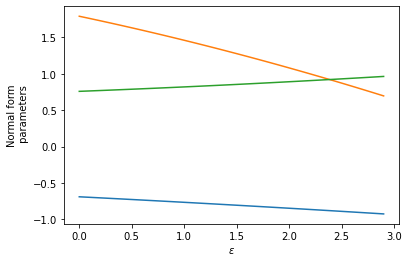

In [30]:
np.random.seed(66)
order = 3
rcoeff = 2 * (np.random.random(size=order) - 0.5) / 10 ** np.arange(order)
b3coeff = 10 * (np.random.random(size=order) - 0.5) / 10 ** np.arange(order)
b5coeff = 1 * (np.random.random(size=order)) / 10 ** np.arange(order)


def r_func(epsilons):
    epsilons = np.asarray(epsilons)
    return np.sum(
        rcoeff[np.newaxis, :]
        * epsilons[:, np.newaxis] ** np.arange(len(rcoeff))[np.newaxis, :],
        axis=1,
    )


def b3_func(epsilons):
    epsilons = np.asarray(epsilons)
    return np.sum(
        b3coeff[np.newaxis, :]
        * epsilons[:, np.newaxis] ** np.arange(len(b3coeff))[np.newaxis, :],
        axis=1,
    )


def b5_func(epsilons):
    epsilons = np.asarray(epsilons)
    return np.sum(
        b5coeff[np.newaxis, :]
        * epsilons[:, np.newaxis] ** np.arange(len(b5coeff))[np.newaxis, :],
        axis=1,
    )


epsilons = np.arange(0, 3, 0.1)
inds = np.intersect1d(
    np.where(r_func(epsilons) < 0)[0], np.where(b3_func(epsilons) > 0)[0]
)
plt.plot(epsilons, r_func(epsilons))
plt.plot(epsilons, b3_func(epsilons))
plt.plot(epsilons, b5_func(epsilons))
plt.xlabel(r"$\varepsilon$")
plt.ylabel("Normal form\n parameters")
plt.show()

In [31]:
num_trajectories = 3
np.random.seed(1)
epsilons_train = 1 + 2 * (np.random.random(size=num_trajectories))
rs = r_func(epsilons_train)
b3s = b3_func(epsilons_train)
b5s = b5_func(epsilons_train)
k = 2

np.random.seed(10)

xs = []
for i in range(len(rs)):
    print(i)
    u0 = utils.get_sh_ic(1.0, spatial_grid)
    us = utils.get_sh_trajectory(u0, rs[i], b3s[i], b5s[i], t1, dt, spatial_grid)
    xs = xs + [us]

0
1.0
2.0


Fit the data with weak SINDyCP

In [32]:
start = timeit.default_timer()
library_functions = [lambda x: x, lambda x: x**3, lambda x: x**5]
function_names = [lambda x: x, lambda x: x + x + x, lambda x: x + x + x + x + x]
seed = 100
K = 500
if __name__ == "testing":
    K = 1
np.random.seed(seed)
feature_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    derivative_order=4,
    spatiotemporal_grid=spatiotemporal_grid,
    include_interaction=False,
    function_names=function_names,
    K=K,
    H_xt=[L / 20, t1 / 20],
)
library_functions = [lambda x: x, lambda x: x**2]
function_names = [lambda x: x, lambda x: x + "^2"]
np.random.seed(seed)
parameter_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    derivative_order=0,
    spatiotemporal_grid=spatiotemporal_grid,
    include_interaction=False,
    function_names=function_names,
    include_bias=True,
    K=K,
    H_xt=[L / 20, t1 / 20],
)
lib = ps.ParameterizedLibrary(
    parameter_library=parameter_lib,
    feature_library=feature_lib,
    num_parameters=1,
    num_features=1,
)
opt = ps.STLSQ(threshold=1e-3, alpha=1e-4, normalize_columns=False)
model = ps.SINDy(feature_library=lib, optimizer=opt, feature_names=["u", "epsilon"])
noise_scale = 0.01
xs_noisy = [
    xs[i] * (1 + noise_scale * np.random.normal(size=xs[i].shape))
    for i in range(len(xs))
]
model.fit(
    xs_noisy, u=epsilons_train.tolist(), t=dt, multiple_trajectories=True, unbias=True
)
model.print()
stop = timeit.default_timer()
print(stop - start)
print(lib.get_feature_names(["u", "epsilon"]))
print(model.score(xs, u=epsilons_train.tolist(), t=dt, multiple_trajectories=True))

(u)' = -1.686 1 u + 1.720 1 uuu + -0.647 1 uuuuu + -0.015 1 u_1 + -2.047 1 u_11 + -0.014 1 u_111 + -1.042 1 u_1111 + -0.081 epsilon u + -0.201 epsilon uuu + -0.220 epsilon uuuuu + 0.024 epsilon u_1 + 0.046 epsilon u_11 + 0.011 epsilon u_111 + -0.061 epsilon^2 uuu + 0.052 epsilon^2 uuuuu + -0.008 epsilon^2 u_1 + -0.010 epsilon^2 u_11 + -0.003 epsilon^2 u_111 + 0.017 epsilon^2 u_1111
3.0308638999999857
['1 u', '1 uuu', '1 uuuuu', '1 u_1', '1 u_11', '1 u_111', '1 u_1111', 'epsilon u', 'epsilon uuu', 'epsilon uuuuu', 'epsilon u_1', 'epsilon u_11', 'epsilon u_111', 'epsilon u_1111', 'epsilon^2 u', 'epsilon^2 uuu', 'epsilon^2 uuuuu', 'epsilon^2 u_1', 'epsilon^2 u_11', 'epsilon^2 u_111', 'epsilon^2 u_1111']
0.9999997278915306


Define some functions to store the fit results

In [33]:
uxcoeff_fit = np.array(
    [
        opt.coef_[0, np.where(np.array(model.get_feature_names()) == "1 u_1")[0][0]],
        opt.coef_[
            0, np.where(np.array(model.get_feature_names()) == "epsilon u_1")[0][0]
        ],
        opt.coef_[
            0, np.where(np.array(model.get_feature_names()) == "epsilon^2 u_1")[0][0]
        ],
    ]
)
uxxcoeff_fit = np.array(
    [
        opt.coef_[0, np.where(np.array(model.get_feature_names()) == "1 u_11")[0][0]],
        opt.coef_[
            0, np.where(np.array(model.get_feature_names()) == "epsilon u_11")[0][0]
        ],
        opt.coef_[
            0, np.where(np.array(model.get_feature_names()) == "epsilon^2 u_11")[0][0]
        ],
    ]
)
uxxxcoeff_fit = np.array(
    [
        opt.coef_[0, np.where(np.array(model.get_feature_names()) == "1 u_111")[0][0]],
        opt.coef_[
            0, np.where(np.array(model.get_feature_names()) == "epsilon u_111")[0][0]
        ],
        opt.coef_[
            0, np.where(np.array(model.get_feature_names()) == "epsilon^2 u_111")[0][0]
        ],
    ]
)
uxxxxcoeff_fit = np.array(
    [
        opt.coef_[0, np.where(np.array(model.get_feature_names()) == "1 u_1111")[0][0]],
        opt.coef_[
            0, np.where(np.array(model.get_feature_names()) == "epsilon u_1111")[0][0]
        ],
        opt.coef_[
            0, np.where(np.array(model.get_feature_names()) == "epsilon^2 u_1111")[0][0]
        ],
    ]
)


def ux_func_fit(epsilons):
    epsilons = np.asarray(epsilons)
    return np.sum(
        uxcoeff_fit[np.newaxis, :]
        * epsilons[:, np.newaxis] ** np.arange(len(rcoeff))[np.newaxis, :],
        axis=1,
    )


def uxx_func_fit(epsilons):
    epsilons = np.asarray(epsilons)
    return np.sum(
        uxxcoeff_fit[np.newaxis, :]
        * epsilons[:, np.newaxis] ** np.arange(len(rcoeff))[np.newaxis, :],
        axis=1,
    )


def uxxx_func_fit(epsilons):
    epsilons = np.asarray(epsilons)
    return np.sum(
        uxxxcoeff_fit[np.newaxis, :]
        * epsilons[:, np.newaxis] ** np.arange(len(rcoeff))[np.newaxis, :],
        axis=1,
    )


def uxxxx_func_fit(epsilons):
    epsilons = np.asarray(epsilons)
    return np.sum(
        uxxxxcoeff_fit[np.newaxis, :]
        * epsilons[:, np.newaxis] ** np.arange(len(rcoeff))[np.newaxis, :],
        axis=1,
    )


rcoeff_fit = np.array(
    [
        opt.coef_[0, np.where(np.array(model.get_feature_names()) == "1 u")[0][0]] + 1,
        opt.coef_[
            0, np.where(np.array(model.get_feature_names()) == "epsilon u")[0][0]
        ],
        opt.coef_[
            0, np.where(np.array(model.get_feature_names()) == "epsilon^2 u")[0][0]
        ],
    ]
)
b3coeff_fit = np.array(
    [
        opt.coef_[0, np.where(np.array(model.get_feature_names()) == "1 uuu")[0][0]],
        opt.coef_[
            0, np.where(np.array(model.get_feature_names()) == "epsilon uuu")[0][0]
        ],
        opt.coef_[
            0, np.where(np.array(model.get_feature_names()) == "epsilon^2 uuu")[0][0]
        ],
    ]
)
b5coeff_fit = np.array(
    [
        -opt.coef_[0, np.where(np.array(model.get_feature_names()) == "1 uuuuu")[0][0]],
        -opt.coef_[
            0, np.where(np.array(model.get_feature_names()) == "epsilon uuuuu")[0][0]
        ],
        -opt.coef_[
            0, np.where(np.array(model.get_feature_names()) == "epsilon^2 uuuuu")[0][0]
        ],
    ]
)


def r_func_fit(epsilons):
    epsilons = np.asarray(epsilons)
    return np.sum(
        rcoeff_fit[np.newaxis, :]
        * epsilons[:, np.newaxis] ** np.arange(len(rcoeff))[np.newaxis, :],
        axis=1,
    )


def b3_func_fit(epsilons):
    epsilons = np.asarray(epsilons)
    return np.sum(
        b3coeff_fit[np.newaxis, :]
        * epsilons[:, np.newaxis] ** np.arange(len(b3coeff))[np.newaxis, :],
        axis=1,
    )


def b5_func_fit(epsilons):
    epsilons = np.asarray(epsilons)
    return np.sum(
        b5coeff_fit[np.newaxis, :]
        * epsilons[:, np.newaxis] ** np.arange(len(b5coeff))[np.newaxis, :],
        axis=1,
    )

Stability of continuation orbits. The solutions have been continued with auto07p and their stability determined and saved.

In [34]:
i = 0
odd_unstable_xs = []
odd_unstable_ys = []
while os.path.exists("data/auto/odd/unstable_" + str(i) + ".npy"):
    branchx, branchy = np.load("data/auto/odd/unstable_" + str(i) + ".npy")
    odd_unstable_xs.append(branchx)
    odd_unstable_ys.append(branchy)
    i = i + 1

i = 0
odd_stable_xs = []
odd_stable_ys = []
while os.path.exists("data/auto/odd/stable_" + str(i) + ".npy"):
    branchx, branchy = np.load("data/auto/odd/stable_" + str(i) + ".npy")
    odd_stable_xs.append(branchx)
    odd_stable_ys.append(branchy)
    i = i + 1

i = 0
even_unstable_xs = []
even_unstable_ys = []
while os.path.exists("data/auto/even/unstable_" + str(i) + ".npy"):
    branchx, branchy = np.load("data/auto/even/unstable_" + str(i) + ".npy")
    even_unstable_xs.append(branchx)
    even_unstable_ys.append(branchy)
    i = i + 1

i = 0
even_stable_xs = []
even_stable_ys = []
while os.path.exists("data/auto/even/stable_" + str(i) + ".npy"):
    branchx, branchy = np.load("data/auto/even/stable_" + str(i) + ".npy")
    even_stable_xs.append(branchx)
    even_stable_ys.append(branchy)
    i = i + 1

i = 0
periodic_unstable_xs = []
periodic_unstable_ys = []
while os.path.exists("data/auto/periodic/unstable_" + str(i) + ".npy"):
    branchx, branchy = np.load("data/auto/periodic/unstable_" + str(i) + ".npy")
    periodic_unstable_xs.append(branchx)
    periodic_unstable_ys.append(branchy)
    i = i + 1

i = 0
periodic_stable_xs = []
periodic_stable_ys = []
while os.path.exists("data/auto/periodic/stable_" + str(i) + ".npy"):
    branchx, branchy = np.load("data/auto/periodic/stable_" + str(i) + ".npy")
    periodic_stable_xs.append(branchx)
    periodic_stable_ys.append(branchy)
    i = i + 1

Plot the normal form parameters and continuation results

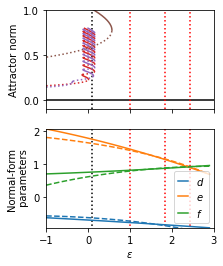

In [35]:
colors = [
    "#ff7f0e",
    "#2ca02c",
    "#1f77b4",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

plt.subplots(2, 1, figsize=(3, 4))

plt.subplot(2, 1, 1)
plt.plot(np.arange(-1, 4, 1), np.zeros(5), c="black")
for epsilon in epsilons_train:
    plt.plot([epsilon, epsilon], [-0.1, 1], ls=":", c="red")
plt.plot([0.1, 0.1], [-0.1, 1], ls=":", c="black")

for i in range(len(odd_stable_xs)):
    plt.plot(odd_stable_xs[i], odd_stable_ys[i], c=colors[3])
for i in range(len(odd_unstable_xs)):
    plt.plot(odd_unstable_xs[i], odd_unstable_ys[i], ls=":", c=colors[3])

for i in range(len(even_stable_xs)):
    plt.plot(even_stable_xs[i], even_stable_ys[i], c=colors[4])
for i in range(len(even_unstable_xs)):
    plt.plot(even_unstable_xs[i], even_unstable_ys[i], ls=":", c=colors[4])

for i in range(len(periodic_stable_xs)):
    plt.plot(periodic_stable_xs[i], periodic_stable_ys[i], c=colors[5])
for i in range(len(periodic_unstable_xs)):
    plt.plot(periodic_unstable_xs[i], periodic_unstable_ys[i], ls=":", c=colors[5])

plt.xlim(-1, 3)
plt.ylim(-0.1, 1)
plt.ylabel("Attractor norm")
plt.gca().set_xticklabels([])

plt.subplot(2, 1, 2)
epsilons = np.arange(-1, 3, 0.1)
mn = np.min([r_func(epsilons), b3_func(epsilons), b5_func(epsilons)])
mx = np.max([r_func(epsilons), b3_func(epsilons), b5_func(epsilons)])
for epsilon in epsilons_train:
    plt.plot([epsilon, epsilon], [mx, mn], ls=":", c="red")
plt.plot([0.1, 0.1], [mx, mn], ls=":", c="black")

line1 = plt.plot(epsilons, r_func(epsilons), label="$d$")
line2 = plt.plot(epsilons, b3_func(epsilons), label="$e$")
line3 = plt.plot(epsilons, b5_func(epsilons), label="$f$")

plt.plot(
    epsilons,
    1 - (r_func_fit(epsilons) - 1) / uxxxx_func_fit(epsilons),
    c=line1[0].get_color(),
    ls="--",
)
plt.plot(
    epsilons,
    -b3_func_fit(epsilons) / uxxxx_func_fit(epsilons),
    c=line2[0].get_color(),
    ls="--",
)
plt.plot(
    epsilons,
    -b5_func_fit(epsilons) / uxxxx_func_fit(epsilons),
    c=line3[0].get_color(),
    ls="--",
)

h, lab = plt.gca().get_legend_handles_labels()
plt.legend(h, lab, handlelength=1)
plt.ylim(mn, mx)
plt.xlim(-1, 3)
plt.xlabel(r"$\varepsilon$")
plt.ylabel("Normal-form\n parameters")

plt.savefig("fig4a.pdf")
plt.show()

Extrapolate the model to parameters with twentry random initial conditions. The fit correctly predicts the localized states!

In [36]:
def sh_fit(t, u, epsilon):
    ux = np.real(ps.SpectralDerivative(d=1, axis=0)._differentiate(u, L / nx))
    uxx = np.real(ps.SpectralDerivative(d=2, axis=0)._differentiate(u, L / nx))
    uxxx = np.real(ps.SpectralDerivative(d=3, axis=0)._differentiate(u, L / nx))
    uxxxx = np.real(ps.SpectralDerivative(d=4, axis=0)._differentiate(u, L / nx))
    return (
        ux_func_fit([epsilon])[0] * ux
        + uxx_func_fit([epsilon])[0] * uxx
        + uxxx_func_fit([epsilon])[0] * uxxx
        + uxxxx_func_fit([epsilon])[0] * uxxxx
        + (r_func_fit([epsilon])[0] - 1) * u
        + b3_func_fit([epsilon])[0] * u**3
        - b5_func_fit([epsilon])[0] * u**5
    )


nx = 256
L = 2 * np.pi * 16
t1 = 50
if __name__ == "testing":
    n = 64
    t1 = 10
N = nx
dt = 1

epsilon = 0.1
k = 2

xs_test = []
seeds = [13, 15]
for i in seeds:
    np.random.seed(i)
    ks = np.arange(-20, 21) / L
    u0 = np.zeros((nx), dtype=np.complex128)
    scale0 = 0.5
    for kx in ks:
        scale = scale0 / (1 + np.abs(L * kx) ** 0.5)
        u0 += (
            scale
            * (np.random.normal(0, 1) + 1j * np.random.normal(0, 1))
            * np.exp(1j * (2 * np.pi * kx * np.arange(nx) / nx * L))
        )
    u = np.real(u0)
    us = np.zeros((int(t1 / dt), nx))

    t = 0
    for n in range(int(t1 / dt)):
        t = n * dt
        print("%d %.3f" % (i, t / t1), end="\r")
        sol = solve_ivp(
            sh_fit,
            [t, t + dt],
            u,
            method="LSODA",
            args=(epsilon,),
            rtol=1e-6,
            atol=1e-6,
            first_step=dt / 1000,
        )
        u = sol.y[:, -1]
        us[n] = u
    xs_test.append(np.transpose(us)[:, :, np.newaxis])

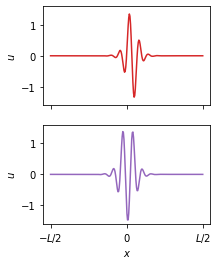

In [37]:
plt.subplots(2, 1, figsize=(3, 4))

plt.subplot(2, 1, 1)
u = xs_test[0][:, -1]
ux = ps.SpectralDerivative(d=1, axis=0)._differentiate(u, L / nx)
u = np.roll(u, nx // 2 - np.argmax(ux) + 1)
plt.plot(u, c=colors[3])
plt.ylim(-1.6, 1.6)
plt.ylabel("$u$")
plt.gca().set_xticks([0, 128, 256])
plt.gca().set_xticklabels([])

plt.subplot(2, 1, 2)
u = xs_test[1][:, -1]
u = np.roll(u, nx // 2 - np.argmin(u) + 1)
plt.plot(u, c=colors[4])
plt.ylim(-1.6, 1.6)
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.gca().set_xticks([0, 128, 256])
plt.gca().set_xticklabels(["$-L/2$", "$0$", "$L/2$"])

plt.savefig("fig4b.pdf")